In [0]:
from google.colab import drive
drive.mount('../content/train')

# These codes are running in Google Colab. The drive must be assigned before running codes. 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/train


In [0]:
from google.colab import files
uploaded = files.upload()

# Any necessary file must be loaded. If you are running in local machine, you can delete the codes and above. 

Saving data_preparation.py to data_preparation.py
Saving seed_analysis.py to seed_analysis.py
Saving word_extraction.py to word_extraction.py


In [0]:
from __future__ import print_function
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
from google.oauth2 import service_account
from pandas.io import gbq
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# use the key json file from Google console to access the bigquery. 
# Index files for seed and antiseed must be uploaded to your own console first
# You can find those index files in the data folder
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./patent-158782975da6.json"
PROJECT_ID = "patent-241915"
DEST_DATASET = 'claims_analysis'

In [0]:
from word2vec import W2VModelDownload

bq_project = 'patent-landascape'

model_name = '5.9m'
model_download = W2VModelDownload(bq_project)
model_download.download_w2v_model('patent_landscapes', model_name)
print('Done downloading model {}!'.format(model_name))

Completed downloading 5.9m files
Done downloading model 5.9m!


Download the [pretrained model](https://console.cloud.google.com/bigquery?project=patent-225222&folder&organizationId&p=patent-225222&d=claims_analysis&page=dataset) by 5.9 million patents with word2vec. It also assigns the Google Cloud. You can find more instructions in Google Cloud Service. 

In [0]:
from word2vec import Word2Vec

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

In [0]:
# including files we customized
from data_preparation import data_preparation 
from word_extraction import text_cleaning
from seed_analysis import Visualization

W0706 16:38:39.238532 139875857303424 deprecation_wrapper.py:119] From /content/word2vec.py:32: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
# Use the index files to extract abstracts for seed and antiseed
dp = data_preparation(PROJECT_ID, DEST_DATASET, 20000)
seed, antiseed = dp.load_seed(), dp.load_antiseed()

In [0]:
# Import the title and CPC number for our training dataset
seed = pd.read_csv('seed_abstract.csv')
antiseed = pd.read_csv('antiseed_abstract.csv')

These datasets are already mannually labelled

In [0]:
seed.head()

,publication_number,title,abstract
0,US-6652816-B2,Apparatus for generating ozone and anion,An apparatus for generating ozone and anion ca...
1,US-4655910-A,Liquid filtering device,"Liquid filter devices, particularly for irriga..."
2,US-3996136-A,Pump-filter for bilge water,A housing for a bilge pump-filter has a lower ...
3,US-6036178-A,Device for mixing air and water in a water pur...,A device for mixing air and water in a water p...
4,US-5813245-A,Pressure relief circuit for refrigerator conta...,A refrigerator having a water filtration and d...


In [0]:
antiseed.head()

,publication_number,title,abstract,target
0,US-9754200-B2,Method for protecting the authenticity of an a...,method protecting authenticity article imitati...,0
1,US-9805080-B2,Data driven relational algorithm formation for...,techniques described creating algorithm batch ...,0
2,US-2007011724-A1,Mass storage device with automated credentials...,portable mass storage device use factor authen...,0
3,US-2005188291-A1,Error locating methods and devices for algebra...,method decoding point algebraic geometric code...,0
4,US-6546349-B1,Optimal degaussing using an evolution program,evolutionary program calibrate ship degaussing...,0


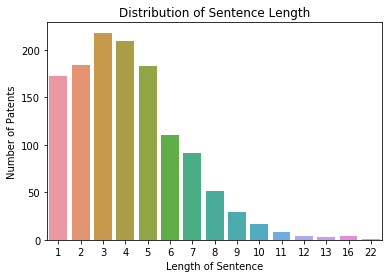

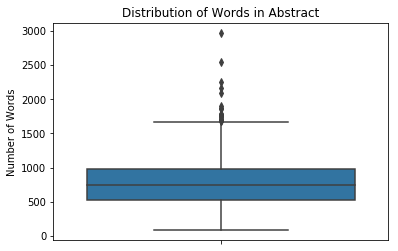

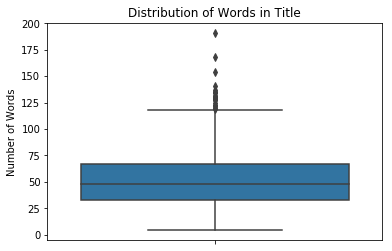

In [0]:
# Display the pictures on seed dataset
viz = Visualization(seed)
viz.number_viz()

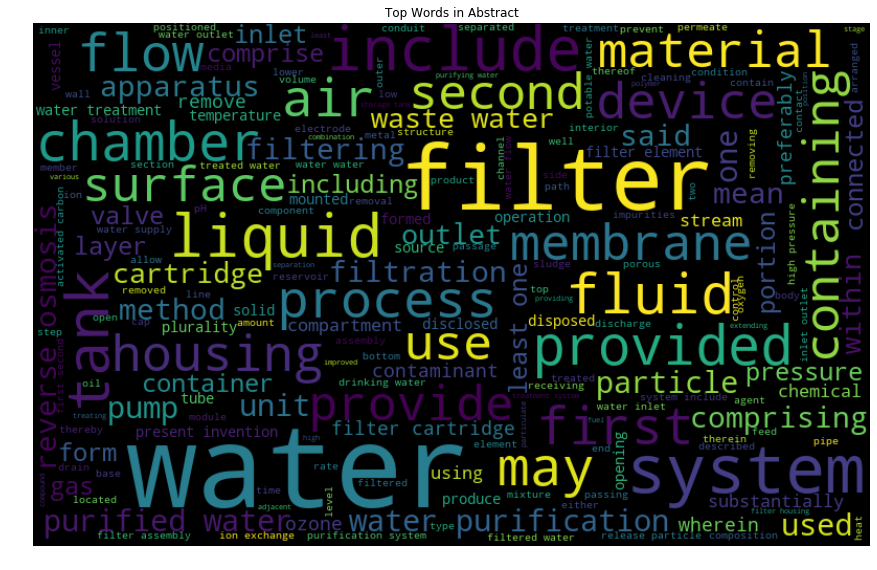

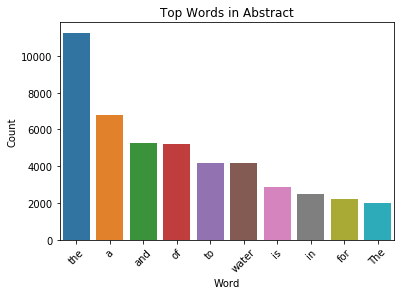

In [0]:
# we can see what words are more popular in training dataset
viz.words_abstract_viz('abstract')

In [0]:
# Display the clean texts on seed datasets
#clean_seed = text_cleaning(seed)
#seed = clean_seed.remove_nonalpha()
seed['abstract'] = seed['abstract'].apply(lambda x: text_cleaning(x).remove_nonalpha())
seed['abstract'] = seed['abstract'].apply(lambda x: text_cleaning(x).remove_stopword())
viz_clean = Visualization(seed)

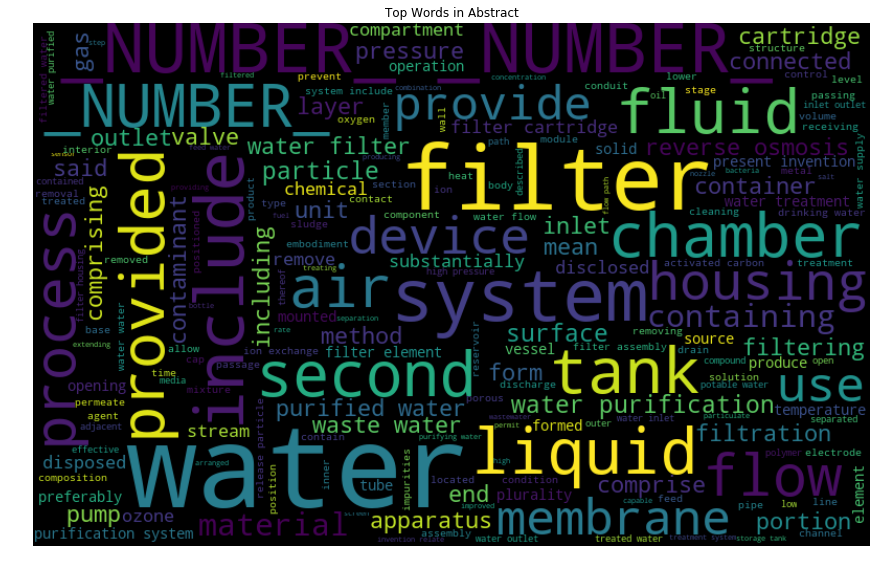

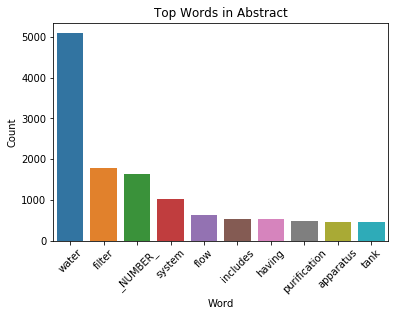

In [0]:
viz_clean.words_abstract_viz('abstract')

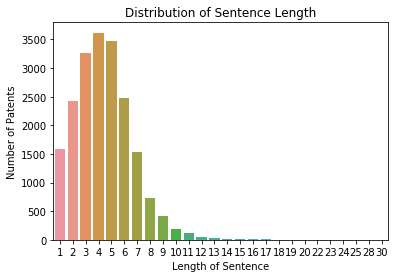

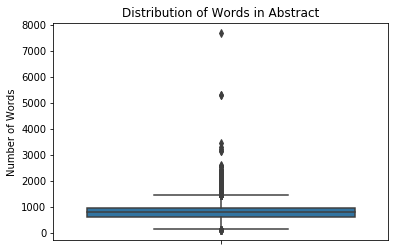

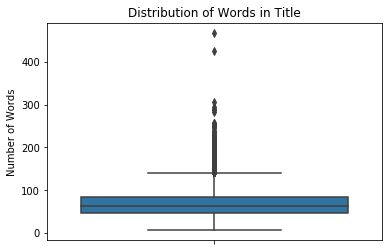

In [0]:
# Display antiseed datasets
viz_antiseed = Visualization(antiseed)
viz_antiseed.number_viz()

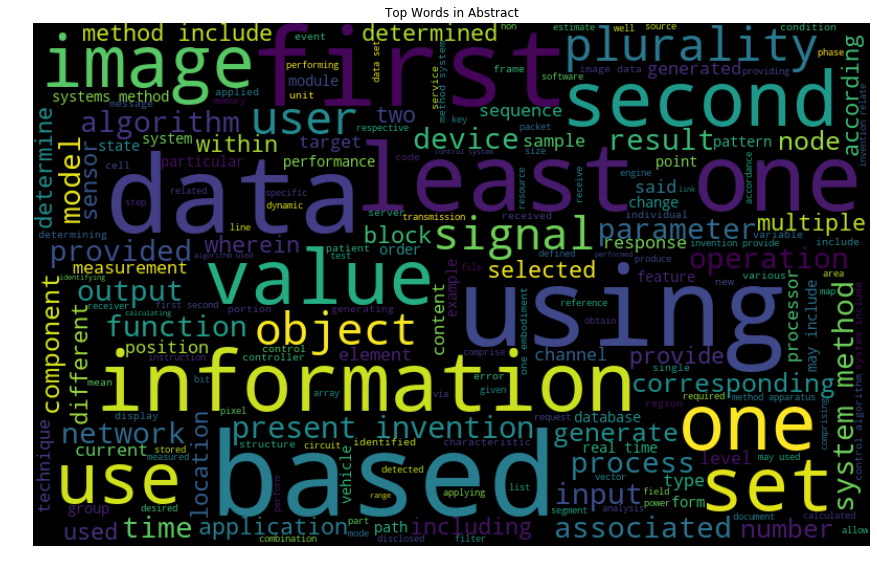

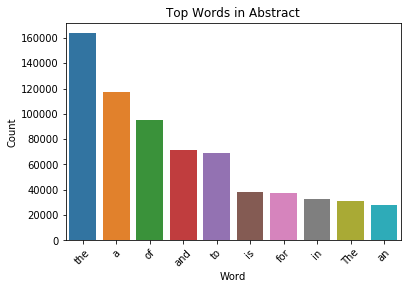

In [0]:
viz_antiseed.words_abstract_viz('abstract')

In [0]:
# Display the antiseed after cleaning abstract
antiseed['abstract'] = antiseed['abstract'].apply(lambda x: text_cleaning(x).remove_nonalpha())
antiseed['abstract'] = antiseed['abstract'].apply(lambda x: text_cleaning(x).remove_stopword())
#clean_antiseed = text_cleaning(antiseed)
#antiseed = clean_antiseed.remove_stopword()
viz_cln_anti = Visualization(antiseed)

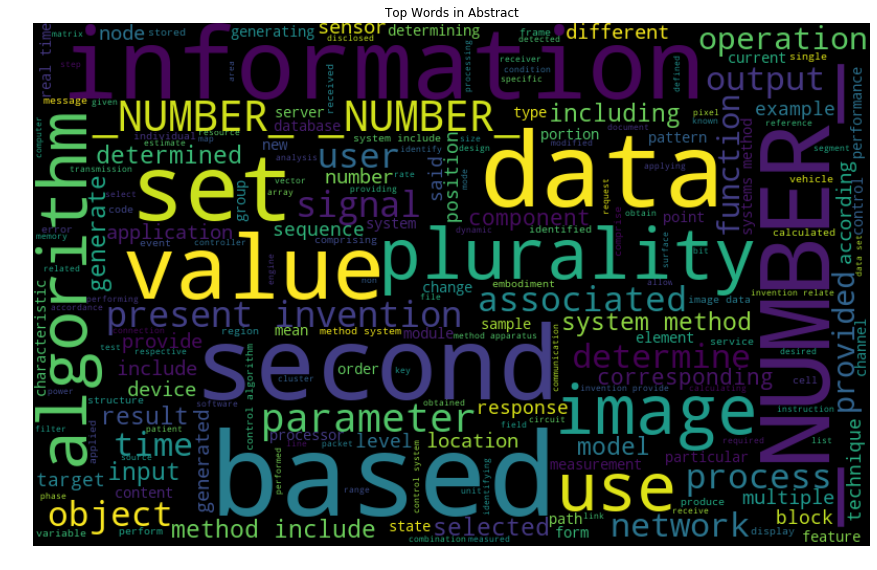

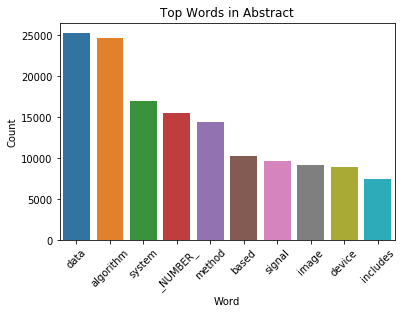

In [0]:
viz_cln_anti.words_abstract_viz('abstract')

In [0]:
# extract keywords from seed dataset and expanded the search results
keywords = clean_seed.key_words_tfidf('abstract')

These key words are ['water purification',
 'reverse osmosis',
 'purified water',
 'waste water',
 'filter cartridge',
 'present invention',
 'water treatment',
 'water filter',
 'filter assembly',
 'purification system']

In [0]:
# Use the keywords to find relevant patents and compose as dataframe
expanded_patent = dp.load_expanded(keywords)


In [0]:
expanded_patent = pd.read_csv('expanded_seed.csv', compression='gzip')

In [0]:
expanded = Visualization(expanded_patent)

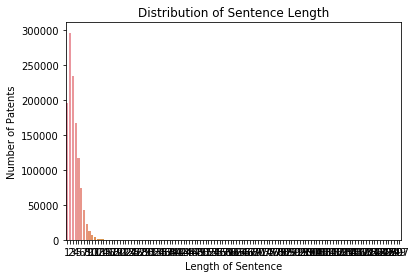

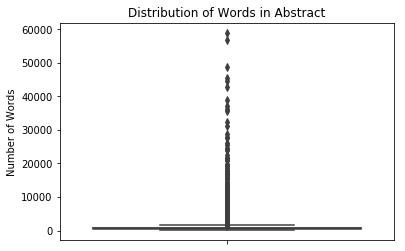

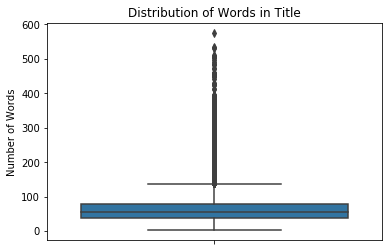

In [0]:
expanded.number_viz()

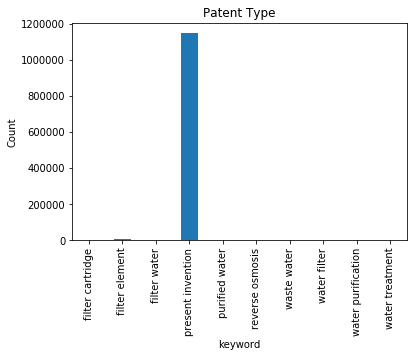

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display the unbalanced datasets of expanded datasets
ep= expanded_patent.groupby('keyword')['keyword'].count()
ep.plot(kind='bar')
plt.ylabel('Count')
plt.title('Patent Type')
plt.show()

In [0]:
# Integrate seed and antiseed as label datasets known as training dataset. 
# Abstract is the input, seed data is labeled as 1 and antiseed labelled as 0
#
seed['target'] = 1
antiseed['target'] = 0

df_label = pd.concat([seed[['abstract', 'target']], antiseed[['abstract', 'target']]], ignore_index=True)

In [0]:
# The expanded dataset is very unbalanced, and is random sampled for testing model 
# Random unlablled data is selected. The patents contain 'present invention' is labelled as 0

expanded_patent['target'] = 1
expanded_patent.loc[expanded_patent['keyword'] == 'present invention', ['target']] = 0
df_unlabel = expanded_patent[['abstract', 'target']]
df_unlabel = df_unlabel[df_unlabel['target'] == 0].sample(n=1050000, random_state=1)

df_sample = df_unlabel.drop(df_unlabel_sample.index).reset_index(drop=True)

In [0]:
# Shuffle the data

df_label = shuffle(df_label, random_state=22)
df_sample = shuffle(df_sample, random_state=22)

In [0]:
## Three feature engineering aproaches are contained in the file. You can select one

from feature_engineering import feature_engineering

In [0]:
fe = feature_engineering(df_label['abstract'], df_sample['abstract'], df_label['target'])
X_label_tf, X_unlabel_tf, y_label_tf = fe.tfidf()

In [0]:
X_label_tfbi, X_unlabel_tfbi, y_label_tfbi = fe.tfidf(unigram=True)

In [0]:
fe = feature_engineering(df_label['abstract'], df_sample['abstract'], df_label['target'], True)
X_label_em, X_unlabel_em, y_label_em, embed_size = fe.word2vec_embedding()

In [0]:
# if the imbalance of training dataset can be also smoothed by over sampling SMOTE too
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(random_state=12, ratio = 1.0)
#X_label_em, y_label_em = sm.fit_sample(X_label_em, y_label_em)

MultinomialNB             CV-5 CV_SCORE: [0.97516779 0.97248322 0.9738255  0.97045989 0.97314535]  TEST_SCORE: 0.9807391168180395
[[95710  1859]
 [17572 11705]]


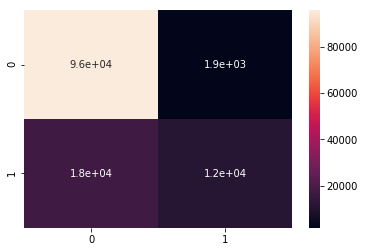

Accuracy: 0.846814247197389
Precision: 0.8629460336184016
Recall: 0.3998018922703829
f1 score: 0.5464391587497958


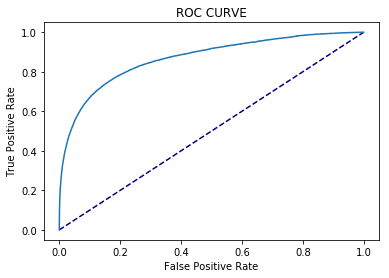

RandomForestClassifier    CV-5 CV_SCORE: [0.99194631 0.98624161 0.9909396  0.98657268 0.98825109]  TEST_SCORE: 0.9912308174130912
[[88280  9289]
 [ 8565 20712]]


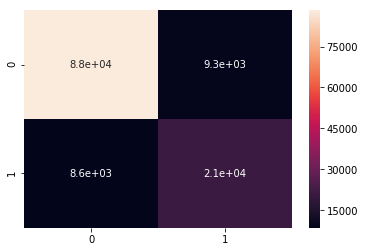

Accuracy: 0.8592466455386847
Precision: 0.6903769874337522
Recall: 0.7074495337637053
f1 score: 0.6988090016532272


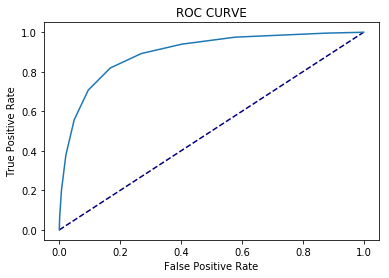

XGBClassifier             CV-5 CV_SCORE: [1.         1.         1.         0.99966432 1.        ]  TEST_SCORE: 0.9998434074538052
[[ 8236 89333]
 [   32 29245]]


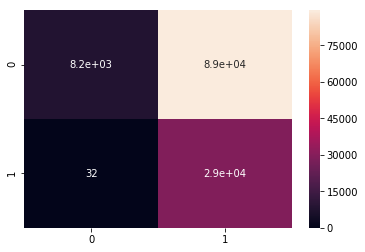

Accuracy: 0.2954842880343093
Precision: 0.24663090961223835
Recall: 0.9989069918365953
f1 score: 0.3955902742551824


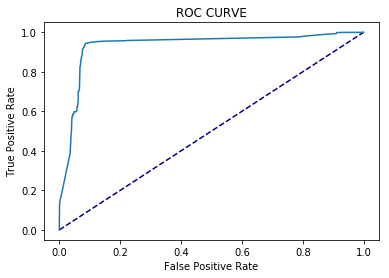

In [0]:
# Apply machine learning model to categorize the patent directly. See this as classification and the feature is tfidf

from ML_Model import ML_Model

models = [MultinomialNB(), RandomForestClassifier(), XGBClassifier()]

for model in models:
  
  model_tf = ML_Model(model, X_label_tf, y_label_tf)

  model_tf.fit()

  model_tf.metric(df_sample['target'].values, X_unlabel_tf)

#model_tr = model_trial([MultinomialNB(),
#            RandomForestClassifier(),
#            XGBClassifier()], X_label, y_label)

MultinomialNB             CV-5 CV_SCORE: [0.97516779 0.97248322 0.9738255  0.97045989 0.97314535]  TEST_SCORE: 0.9807391168180395
[[95710  1859]
 [17572 11705]]


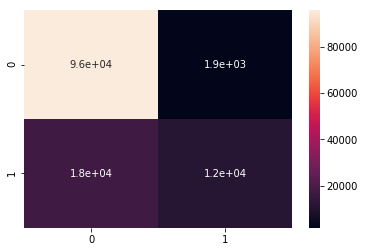

Accuracy: 0.846814247197389
Precision: 0.8629460336184016
Recall: 0.3998018922703829
f1 score: 0.5464391587497958


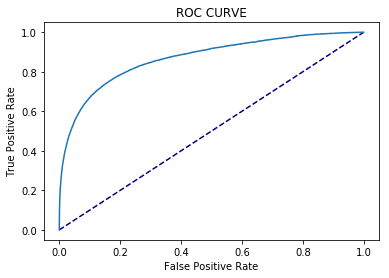

RandomForestClassifier    CV-5 CV_SCORE: [0.99328859 0.9909396  0.98825503 0.99227929 0.98791541]  TEST_SCORE: 0.9901346695897275
[[91514  6055]
 [ 8235 21042]]


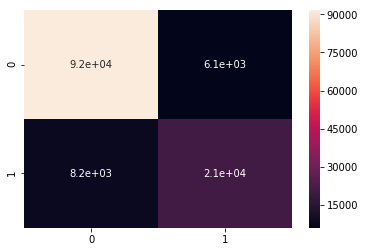

Accuracy: 0.8873437081185059
Precision: 0.7765435288039266
Recall: 0.7187211804488165
f1 score: 0.7465143505871502


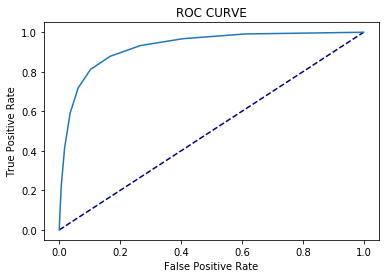

XGBClassifier             CV-5 CV_SCORE: [1.         1.         1.         0.99966432 1.        ]  TEST_SCORE: 0.9998434074538052
[[ 8236 89333]
 [   32 29245]]


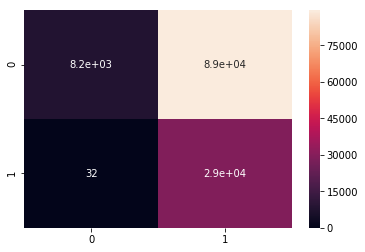

Accuracy: 0.2954842880343093
Precision: 0.24663090961223835
Recall: 0.9989069918365953
f1 score: 0.3955902742551824


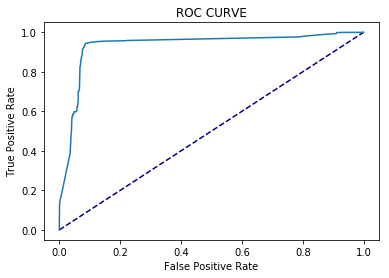

In [0]:
# The feature is tfidf bigram

for model in models:
  
  model_tfbi = ML_Model(model, X_label_tfbi, y_label_tfbi)

  model_tfbi.fit()

  model_tfbi.metric(df_sample['target'].values, X_unlabel_tfbi)

Pseudolabel               CV-5 CV_SCORE: [0.96342282 0.96006711 0.95       0.9503189  0.95602551]  TEST_SCORE: 0.9711869715001565
[[97132   437]
 [20656  8621]]


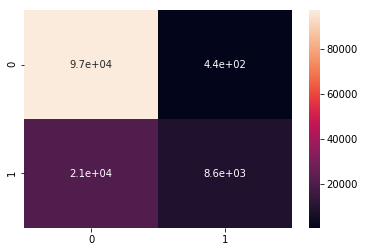

Accuracy: 0.83371174495057
Precision: 0.951755354382866
Recall: 0.294463230522253
f1 score: 0.449771749054389


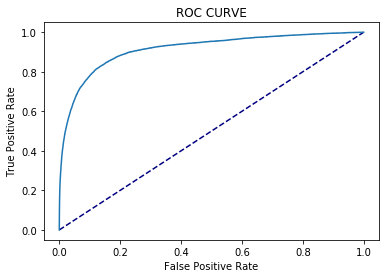

Pseudolabel               CV-5 CV_SCORE: [0.9909396  0.99194631 0.98422819 0.98489426 0.98858677]  TEST_SCORE: 0.9863764484810523
[[94193  3376]
 [ 9529 19748]]


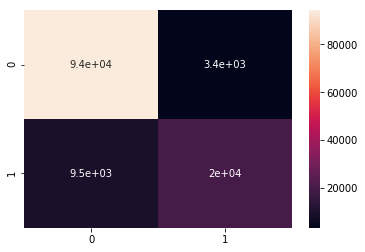

Accuracy: 0.8982624599908551
Precision: 0.8540044974917834
Recall: 0.674522662841138
f1 score: 0.7537260739298868


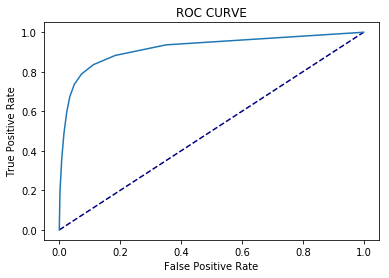

Pseudolabel               CV-5 CV_SCORE: [0.99966443 1.         1.         0.99932863 0.99966432]  TEST_SCORE: 0.9998434074538052
[[ 8529 89040]
 [   41 29236]]


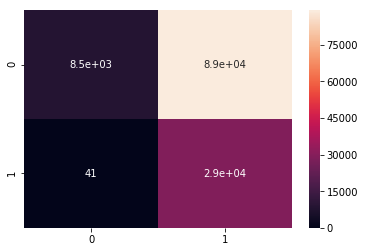

Accuracy: 0.2977232234362928
Precision: 0.24718455138827827
Recall: 0.9985995832906377
f1 score: 0.39627794758493556


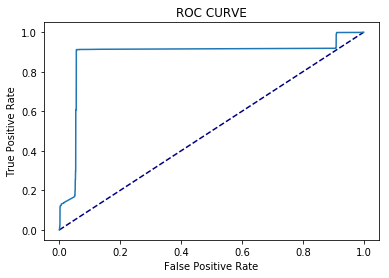

In [0]:
# The project is treated as semi-supervised project. So Pseudo Lable is applied for tfidf with unigram.  

from Pseudolabel import Pseudolabel

for mod in models:
  
  pseudo = Pseudolabel(mod, X_unlabel_tf, 0.3)

  pseudo_model = ML_Model(pseudo, X_label_tf, y_label_tf)

  pseudo_model.fit()

  pseudo_model.metric(df_sample['target'].values, X_unlabel_tf)

Pseudolabel               CV-5 CV_SCORE: [0.96241611 0.96073826 0.95100671 0.95132595 0.95568983]  TEST_SCORE: 0.9721265267773254
[[97105   464]
 [20545  8732]]


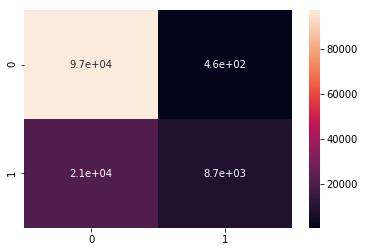

Accuracy: 0.8343739652807342
Precision: 0.9495432796868204
Recall: 0.2982546025890631
f1 score: 0.4539287292386869


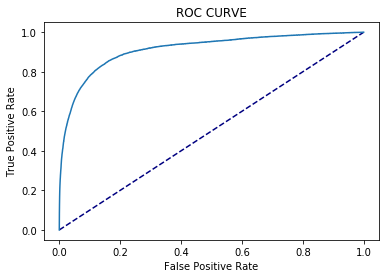

Pseudolabel               CV-5 CV_SCORE: [0.98624161 0.98590604 0.98221477 0.98288016 0.98724404]  TEST_SCORE: 0.9862198559348575
[[92376  5193]
 [ 8695 20582]]


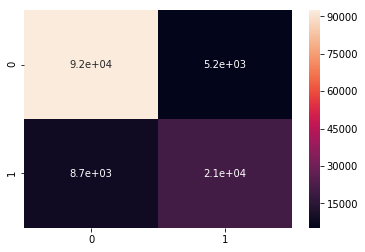

Accuracy: 0.8905129054128629
Precision: 0.798525703200776
Recall: 0.7030091880998737
f1 score: 0.747729419457967


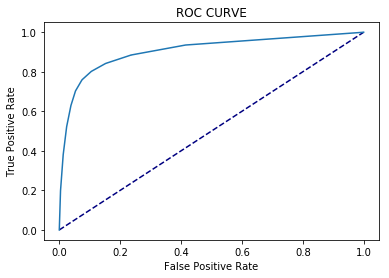

Pseudolabel               CV-5 CV_SCORE: [0.99932886 1.         1.         0.99932863 1.        ]  TEST_SCORE: 0.9998434074538052
[[ 8550 89019]
 [   42 29235]]


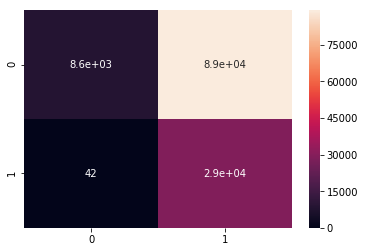

Accuracy: 0.29788089494347475
Precision: 0.24722208128266274
Recall: 0.9985654267855313
f1 score: 0.39632348455578825


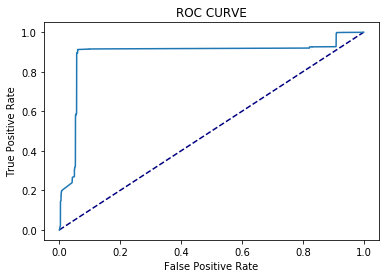

In [0]:
# The feature is applied with tfidf bigram for pseudo label

for mod in models:
  
  pseudo = Pseudolabel(mod, X_unlabel_tfbi, 0.3)

  pseudo_model = ML_Model(pseudo, X_label_tfbi, y_label_tfbi)

  pseudo_model.fit()

  pseudo_model.metric(df_sample['target'].values, X_unlabel_tfbi)

In [0]:
# Fully connected Neural Network with tfidf unigram for classification

from Pseudolabel_NN import Pseudolabel_NN

pseudolabel_nn = Pseudolabel_NN(X_unlabel_tf)

[[78265 19304]
 [ 4037 25240]]


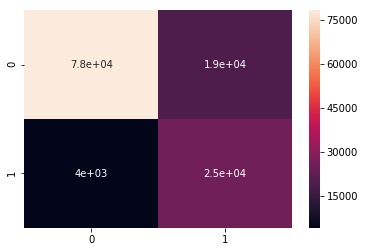

Accuracy: 0.8159894675433202
Precision: 0.5666307471264368
Recall: 0.8621101888854732
f1 score: 0.6838162582462984


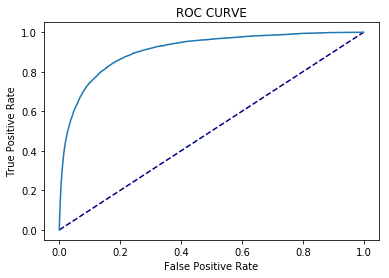

In [0]:
# Fully connected Neural Network with tfidf unigram for semi-supervised algorithm

dnn = pseudolabel_nn.dnn(X_label_tf)

dnn.fit(X_label_tf, y_label_tf, batch_size=128, epochs=2, validation_split=0.1)

y_prob = dnn.predict(X_unlabel_tf,  batch_size=1024,  verbose=1)

y_pred = pseudolabel_nn.predict(y_prob)


pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)

In [0]:
pseudolabel_nn = Pseudolabel_NN(X_unlabel_tf, batch_size = 128)

dnn = pseudolabel_nn.dnn(X_label_tf)

pseudolabel_nn.fit(dnn, X_label_tf, y_label_tf)

W0705 02:58:06.314504 140396342937472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 02:58:06.339514 140396342937472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:515: The name tf.sparse_placeholder is deprecated. Please use tf.compat.v1.sparse_placeholder instead.

W0705 02:58:06.348910 140396342937472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 02:58:06.371615 140396342937472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1083: The name tf.sparse_tensor_dense_matmul is deprecated. Please use tf.sparse.sparse_dense_matmul instead.

W0705 02:58:0

Train on 19155 samples, validate on 2129 samples
Epoch 1/2
19155/19155 [==============================] - 669s 35ms/step - loss: 4.5710 - acc: 0.9636 - val_loss: 0.2024 - val_acc: 0.9883
Epoch 2/2
38053/38053 [==============================] - 50s 1ms/step
Train on 53403 samples, validate on 5934 samples
Epoch 1/2
53403/53403 [==============================] - 1824s 34ms/step - loss: 0.2723 - acc: 0.9411 - val_loss: 0.2767 - val_acc: 0.9156
Epoch 2/2
53403/53403 [==============================] - 1820s 34ms/step - loss: 0.1786 - acc: 0.9564 - val_loss: 0.2451 - val_acc: 0.9248


126846/126846 [==============================] - 163s 1ms/step
[[69481 28088]
 [ 2553 26724]]


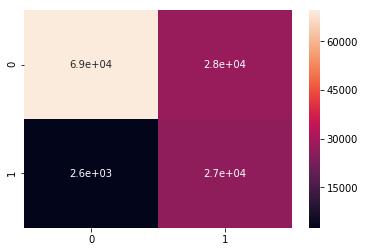

Accuracy: 0.7584393674219132
Precision: 0.4875574691673356
Recall: 0.9127984424633672
f1 score: 0.6356122679541915


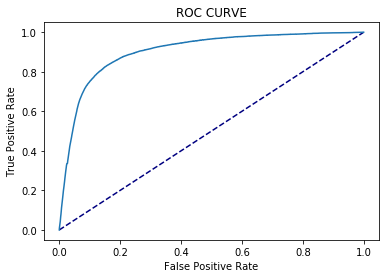

In [0]:

y_prob = pseudolabel_nn.predict_proba(X_unlabel_tf)

y_pred = pseudolabel_nn.predict(y_prob)

pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)

Train on 19155 samples, validate on 2129 samples
Epoch 1/2
19155/19155 [==============================] - 615s 32ms/step - loss: 0.0596 - acc: 0.9963 - val_loss: 0.0436 - val_acc: 0.9948
Epoch 2/2
126846/126846 [==============================] - 160s 1ms/step
[[67487 30082]
 [ 2615 26662]]


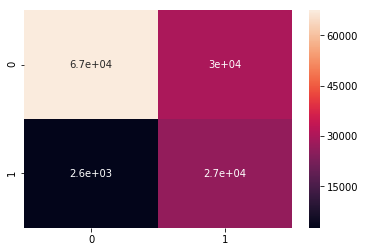

Accuracy: 0.74223073648361
Precision: 0.46986465529395177
Recall: 0.9106807391467705
f1 score: 0.6198951418839586


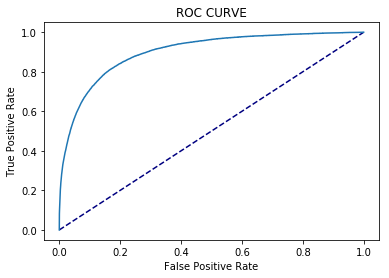

In [0]:
# Fully connected Neural Network with tfidf bigram for classification

pseudolabel_nn = Pseudolabel_NN(X_unlabel_tfbi)

dnn.fit(X_label_tfbi, y_label_tfbi, batch_size=128, epochs=2, validation_split=0.1)

y_prob = dnn.predict(X_unlabel_tfbi,  batch_size=1024,  verbose=1)

y_pred = pseudolabel_nn.predict(y_prob)


pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)

In [0]:
# Fully connected Neural Network with tfidf unigram for semi-supervised algorithm

pseudolabel_nn = Pseudolabel_NN(X_unlabel_tfbi, batch_size = 128)

dnn = pseudolabel_nn.dnn(X_label_tfbi)

pseudolabel_nn.fit(dnn, X_label_tfbi, y_label_tfbi)



126846/126846 [==============================] - 160s 1ms/step
[[76507 21062]
 [ 4810 24467]]


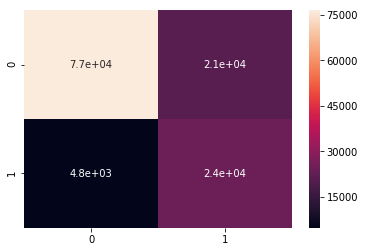

Accuracy: 0.7960361383094461
Precision: 0.537393749039074
Recall: 0.8357072104382279
f1 score: 0.6541453894072667


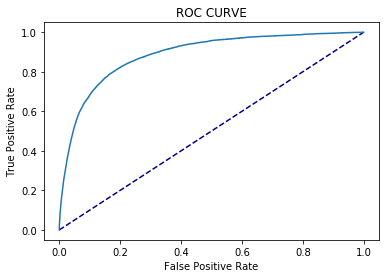

In [0]:
y_prob = pseudolabel_nn.predict_proba(X_unlabel_tfbi)

y_pred = pseudolabel_nn.predict(y_prob)

pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)

In [0]:

# LSTM Neural Network with word vector for classification

pseudolabel_nn = Pseudolabel_NN(X_unlabel_em)

lstm = pseudolabel_nn.nn_emb_batch(w2v_runtime.embedding_weights, embed_size)



lstm.fit(X_label_em, y_label_em, batch_size=32, epochs=2, validation_split=0.1)




W0706 00:12:01.005308 139812974012288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0706 00:12:01.487472 139812974012288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0706 00:12:01.519366 139812974012288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 36000 samples, validate on 4000 samples
Epoch 1/2
36000/36000 [==============================] - 540s 15ms/step - loss: 0.4596 - acc: 0.8961 - val_loss: 0.0968 - val_acc: 0.9790
Epoch 2/2
36000/36000 [==============================] - 540s 15ms/step - loss: 0.2160 - acc: 0.9406 - val_loss: 0.0641 - val_acc: 0.9700


126846/126846 [==============================] - 660s 5ms/step
[[56111 41458]
 [16712 12565]]


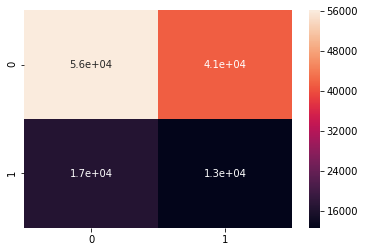

Accuracy: 0.5414124213613358
Precision: 0.2325861207263573
Recall: 0.42917648666188474
f1 score: 0.30168067226890755


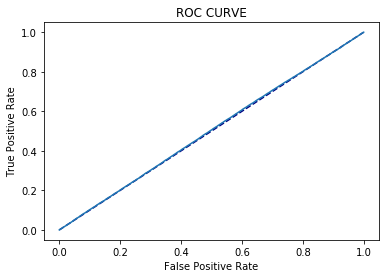

In [0]:
y_prob = lstm.predict(X_unlabel_em,  batch_size=1024,  verbose=1)

y_pred = pseudolabel_nn.predict(y_prob)


pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)


In [0]:
# LSTM Neural Network with word vector for semi-supervised 

pseudolabel_nn = Pseudolabel_NN(X_unlabel_em, batch_size = 32)

lstm = pseudolabel_nn.nn_emb(w2v_runtime.embedding_weights, embed_size)

pseudolabel_nn.fit(lstm, X_label_em, y_label_em)

Train on 36000 samples, validate on 4000 samples
Epoch 1/2
36000/36000 [==============================] - 585s 16ms/step - loss: 0.3221 - acc: 0.9148 - val_loss: 0.0415 - val_acc: 0.9932
Epoch 2/2
38053/38053 [==============================] - 163s 4ms/step
Train on 70247 samples, validate on 7806 samples
Epoch 1/2
70247/70247 [==============================] - 1081s 15ms/step - loss: 0.2492 - acc: 0.9116 - val_loss: 0.2137 - val_acc: 0.9203
Epoch 2/2
70247/70247 [==============================] - 1074s 15ms/step - loss: 0.2188 - acc: 0.9253 - val_loss: 0.1906 - val_acc: 0.9350


126846/126846 [==============================] - 947s 7ms/step
[[55416 42153]
 [16727 12550]]


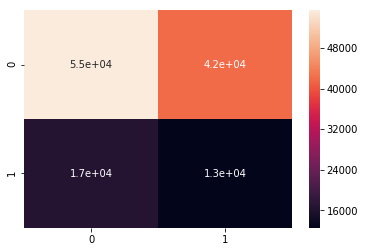

Accuracy: 0.535815082856377
Precision: 0.2294206899073177
Recall: 0.4286641390852888
f1 score: 0.2988806858775899


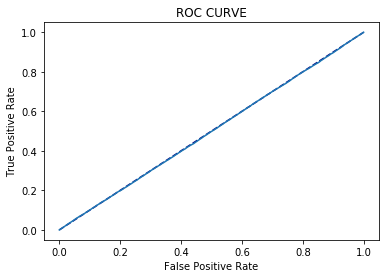

In [0]:
y_prob = pseudolabel_nn.predict_proba(X_unlabel_em)

y_pred = pseudolabel_nn.predict(y_prob)

pseudolabel_nn.metric(df_sample['target'], y_pred, y_prob)



In [0]:
# Show the results

#df_sample['pred'] = y_pred

print('True Positive:', df_sample[(df_sample['pred'] ==1) & (df_sample['target'] ==1)].iloc[0]['abstract'])
print('\n')

print('False Positive:', df_sample[(df_sample['pred'] ==1) & (df_sample['target'] ==0)].iloc[0]['abstract'])
print('\n')

print('False Negative:', df_sample[(df_sample['pred'] ==0) & (df_sample['target'] ==1)].iloc[0]['abstract'])
print('\n')

print('True Negative:', df_sample[(df_sample['pred'] ==0) & (df_sample['target'] ==0)].iloc[0]['abstract'])

True Positive: filtration system cleaning fluid wash tank filtration system includes process tank fluid pumped filter element located wash tank filter element formed hollow porous tubes fluid pumped process tank hollow porous tubes process tank fluid hollow porous tubes greater pressure fluid wash tank submerged fluid particulate matter flow pores tubes wash tank cleaned fluid provided wash tank fluid higher concentration contaminants returned process tank


False Positive: present invention method producing silicon wafer silicon single crystal comprising double polishing step mirror polishing sides wafer sliced silicon single crystal heat treatment step heat treating mirror polished wafer repolishing step polishing surface sides heat treated wafer provided method producing silicon wafer silicon wafer high quality cop free region oxide precipitate free region sufficiently ensured haze foreign body sticking wafer surface contact trace jig wafer surface produced


False Negative: system 